# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


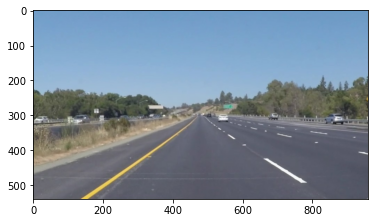

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

# global variables
old_left_ = []
old_right_ = []
old_left_m_ = None
old_right_m_ = None


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def smooth_func(vertices, lines):
    left_m_list = []
    left_b_list = []
    right_m_list = []
    right_b_list = []
    global old_left_, old_right_, old_left_m_, old_right_m_, old_right_b_, old_left_b_

    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # calculate the slope
            m = (y2-y1)/(x2-x1)
            # calculate the intercept
            b = y1 -m*x1
            
            if m<0:
                left_m_list.append(m)
                left_b_list.append(b)
            else:
                right_m_list.append(m)
                right_b_list.append(b)
    
    smooth_list = []
    if len(left_m_list)!=0:

        left_m = sum(left_m_list)/len(left_m_list)
        left_b = sum(left_b_list)/len(left_b_list)
        
        # make sure the angle is not off
        if (old_left_m_ is not None):
            if abs(old_left_m_ - left_m) > 0.10:
                left_m = old_left_m_
                left_b = old_left_b_
            
        x_left = vertices[0][0][0]
        y_left = int(x_left*left_m + left_b)


        x_Lmid = vertices[0][2][0]
        y_Lmid = int(x_Lmid*left_m + left_b)
        
        left = [[x_left,y_left,x_Lmid,y_Lmid]]
        
        # this list includes left and right line's points
        smooth_list.append(left)
        
        # restart the global variables
        old_left_ = left
        old_left_m_ = left_m
        old_left_b_ = left_b
    else:
        smooth_list.append(old_left_)
        


    if len(right_m_list)!=0:

        right_m = sum(right_m_list)/len(right_m_list)
        right_b = sum(right_b_list)/len(right_b_list)

        # make sure the angle is not off
        if (old_right_m_ is not None):
            if abs(old_right_m_ - right_m) > 0.10:
                right_m = old_right_m_
                right_b = old_right_b_

        x_right = vertices[0][1][0]
        y_right = int(x_right*right_m + right_b)

        x_Rmid = vertices[0][3][0]
        y_Rmid = int(x_Rmid*right_m + right_b)
        
        right = [[x_right,y_right,x_Rmid,y_Rmid]]
        
        # this list includes left and right line's points
        smooth_list.append(right)
        
        # restart the global variables
        old_right_ = right
        old_right_m_ = right_m
        old_right_b_ = right_b
        
    else:
        
        smooth_list.append(old_right_)
        
    
    return smooth_list
                
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,vertices, smooth):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if smooth:
        lines = smooth_func(vertices,lines)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
image_list = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

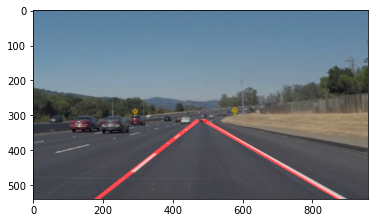

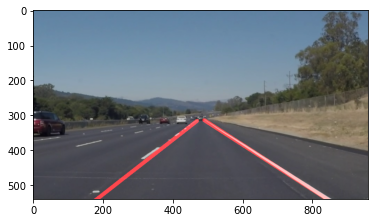

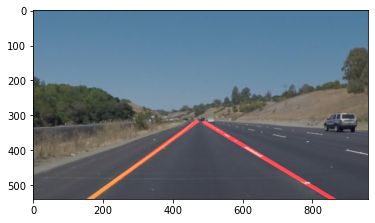

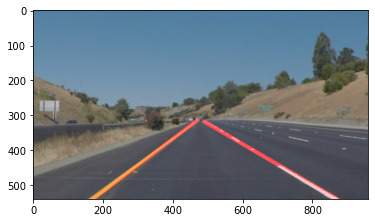

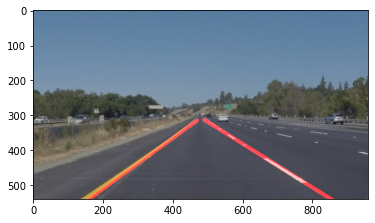

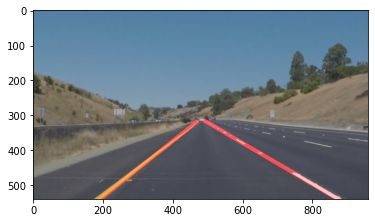

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def line_drawer(image):
    # convert the image to the gray image
    gray_img = grayscale(image)
    
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([100, 255, 255])
    
    # Threshold the HSV image to get only yellow colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # define range of white color in HSV
    lower_white = np.array([0, 0, 205])
    upper_white = np.array([255, 255, 255])
    
    # Threshold the HSV image to get only white colors
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Bitwise-or
    res = cv2.bitwise_or(gray_img,yellow_mask)
    
    # --------------------------------------------------------------

    # apply the Gaussian blur to the image to reduce the noise
    # define kernel_size (the size should be odd number)
    kernel_size = 3
    blur_gray = gaussian_blur(res, kernel_size)

    # apply the edge detection technique (canny)
    low_threshold = 255/3     # all the gradient below this value are ignored
    high_threshold = 255/2   # all the gradient above this value are for sure an edge
    edges = canny(blur_gray, low_threshold, high_threshold)

    # select the region of interest

    # define the vertices of the region of interest
#     vertices1 = np.array([[(140,539),(890,539),(470,305),(490,305)]])
    vertices = np.array([[(image.shape[1]/6.85,image.shape[0]-1),(image.shape[1]/1.08,image.shape[0]-1),(image.shape[1]/2-10,image.shape[0]/1.77),(image.shape[1]/2+10,image.shape[0]/1.77)]])
    vertices = vertices.astype(int)
    masked_image = region_of_interest(edges, vertices)

    # apply the Hogh Transform to detect the lines\
    # define the resolution for checking the line in each pixel
    rho = 1
    theta = 1*np.pi/180
    # define the minimum number of intersections 
    threshold = 15
    # define the min length of the acceptable line
    min_line_len = 40
    # define the max distance of the segments that are allowed to be connected
    max_line_gap = 80
    # choose if you need to smooth the line
    smooth = True

    line = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, vertices, smooth)


    # draw lines on the original image
    line_image = weighted_img(line, image, α=0.8, β=1., γ=0.)


    # disply the image
    # plt.imshow(gray_img, cmap='gray')
#     plt.imshow(line_image)
    
    
    

    # save all the images\
    # directory to save all the image
    Dir = r'C:\Users\hosse\Documents\UDACITY\full_self_driving_car\CarND-LaneLines-P1\test_image_outout'

    # gray scale
    gray_image_name = Dir+'\gray_image.jpg'
    cv2.imwrite(gray_image_name, gray_img)

    # blur image
    blur_image_name = Dir+'\gray2_image.jpg'
    cv2.imwrite(blur_image_name, blur_gray)

    # edges image
    edges_image_name = Dir+'\edges_image.jpg'
    cv2.imwrite(edges_image_name, edges)


    # hogh lines image
    hough_image_name = Dir+'\hough_image.jpg'
    cv2.imwrite(hough_image_name, cv2.cvtColor(line, cv2.COLOR_RGB2BGR))

    # masked image
    masked_image_name = Dir+'\masked_image.jpg'
    cv2.imwrite(masked_image_name, cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))

    # line image
    line_image_name = Dir+'\line_image.jpg'
    cv2.imwrite(line_image_name, cv2.cvtColor(line_image, cv2.COLOR_RGB2BGR))
    
    return line_image
    
    
# check all the images
Dir = r'C:\Users\hosse\Documents\UDACITY\full_self_driving_car\CarND-LaneLines-P1\test_image_outout'
for im in image_list:
    
#     image = mpimg.imread('test_images/solidYellowLeft.jpg')
    image = mpimg.imread('test_images/'+im)
    line_image = line_drawer(image)
    plt.figure()
    plt.imshow(line_image,cmap='gray')
    cv2.imwrite(Dir+'/'+im, cv2.cvtColor(line_image, cv2.COLOR_RGB2BGR))



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [84]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return line_drawer(image)

Let's try the one with the solid white lane on the right first ...

In [79]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                                                                                                       
t:  59%|███████████████████████████████████████▌                           | 148/251 [52:51<00:10, 10.10it/s, now=None]
                                                                                                                       
t:  59%|███████████████████████████████████████▌                           | 148/251 [37:58<00:09, 10.49it/s, now=None]

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4





t:   1%|▌                                                                    | 2/221 [00:00<00:22,  9.76it/s, now=None]

t:   2%|█▏                                                                   | 4/221 [00:00<00:19, 11.17it/s, now=None]

t:   3%|█▊                                                                   | 6/221 [00:00<00:17, 12.54it/s, now=None]

t:   4%|██▍                                                                  | 8/221 [00:00<00:15, 13.71it/s, now=None]

t:   5%|███                                                                 | 10/221 [00:00<00:14, 14.30it/s, now=None]

t:   5%|███▋                                                                | 12/221 [00:00<00:14, 14.77it/s, now=None]

t:   6%|████▎                                                               | 14/221 [00:00<00:13, 15.69it/s, now=None]

t:   7%|████▉                                                               | 16/221 [00:01<00:12, 16.25it/s, now=None]

t:   8%|█████▌                

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 13.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [31]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4




t:  39%|█████████████████████████▉                                         | 264/681 [00:15<00:25, 16.11it/s, now=None]


t:  78%|███████████████████████████████████████████████████▉               | 528/681 [00:31<00:08, 17.68it/s, now=None]


t:  59%|███████████████████████████████████████▌                           | 148/251 [10:15<00:10, 10.10it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 40.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [85]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

                                                                                                                       
t:  59%|███████████████████████████████████████▌                           | 148/251 [54:46<00:10, 10.10it/s, now=None]
                                                                                                                       
t:  59%|███████████████████████████████████████▌                           | 148/251 [39:52<00:09, 10.49it/s, now=None]

t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4





t:   1%|▌                                                                    | 2/251 [00:00<00:27,  8.97it/s, now=None]

t:   1%|▊                                                                    | 3/251 [00:00<00:27,  9.13it/s, now=None]

t:   2%|█                                                                    | 4/251 [00:00<00:26,  9.35it/s, now=None]

t:   2%|█▎                                                                   | 5/251 [00:00<00:26,  9.43it/s, now=None]

t:   3%|█▉                                                                   | 7/251 [00:00<00:25,  9.68it/s, now=None]

t:   4%|██▍                                                                  | 9/251 [00:00<00:24,  9.80it/s, now=None]

t:   4%|██▋                                                                 | 10/251 [00:01<00:26,  9.16it/s, now=None]

t:   4%|██▉                                                                 | 11/251 [00:01<00:28,  8.36it/s, now=None]

t:   5%|███▎                  

t:  74%|█████████████████████████████████████████████████▋                 | 186/251 [00:19<00:07,  9.23it/s, now=None]

t:  75%|█████████████████████████████████████████████████▉                 | 187/251 [00:19<00:06,  9.40it/s, now=None]

t:  75%|██████████████████████████████████████████████████▏                | 188/251 [00:19<00:06,  9.44it/s, now=None]

t:  76%|██████████████████████████████████████████████████▋                | 190/251 [00:19<00:06,  9.74it/s, now=None]

t:  76%|██████████████████████████████████████████████████▉                | 191/251 [00:19<00:06,  9.76it/s, now=None]

t:  77%|███████████████████████████████████████████████████▌               | 193/251 [00:19<00:05, 10.04it/s, now=None]

t:  78%|████████████████████████████████████████████████████               | 195/251 [00:19<00:05, 10.25it/s, now=None]

t:  78%|████████████████████████████████████████████████████▌              | 197/251 [00:20<00:05, 10.16it/s, now=None]

t:  79%|████████████████████████

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 26.5 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))